In [ ]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Pictures import & pre-processing

In [ ]:
import pathlib

data_model = pathlib.Path("/content/drive/MyDrive/Jedha/Final_project/cars_pic/cars_model")
print(data_model)

/content/drive/MyDrive/Jedha/Final_project/cars_pic/cars_model


In [ ]:
for item in data_model.iterdir():
  print(item)

FileNotFoundError: ignored

In [ ]:
# Creation an ImageDataGenerator object in order to use data augmentation on the cars pictures

img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.2)

In [ ]:
# Now we are able to set up the target image size and the batch size

img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/drive/MyDrive/Jedha/Final_project/cars_pic/cars_model",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/drive/MyDrive/Jedha/Final_project/cars_pic/cars_model",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

FileNotFoundError: ignored

Label : 2008


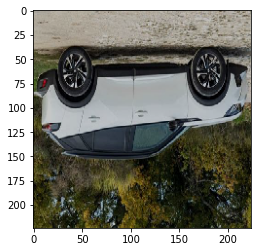

Label : C5 Aircross


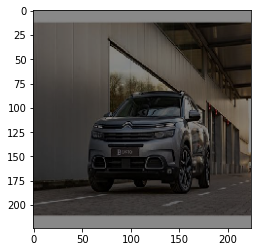

Label : 108


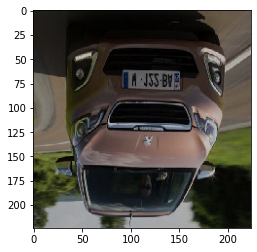

Label : Berlingo


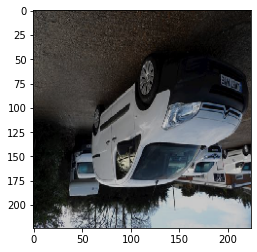

Label : 308


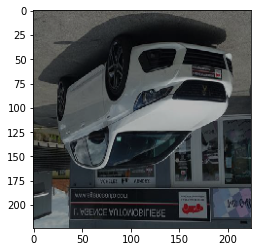

Label : 108


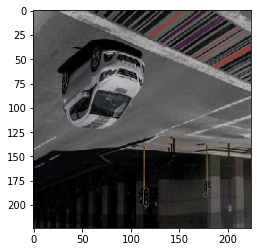

Label : Aygo


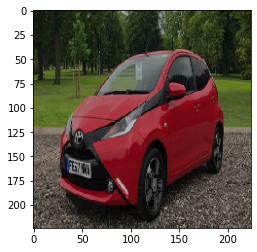

Label : 2008


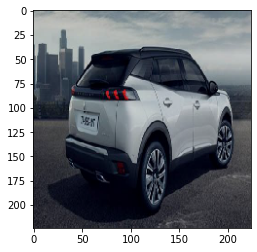

Label : Megane


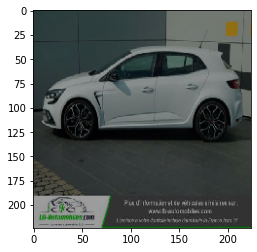

Label : Megane


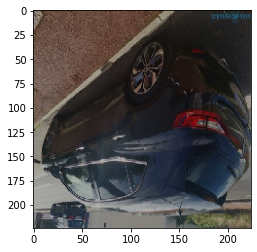

Label : Aygo


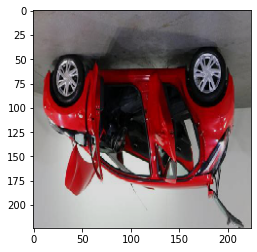

Label : Golf


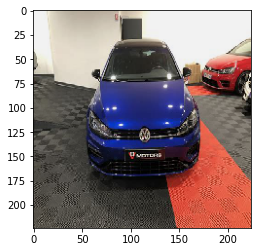

Label : C3


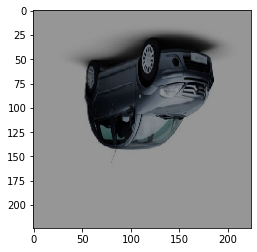

Label : Zoe


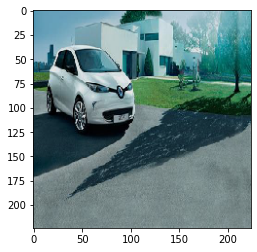

Label : Corolla


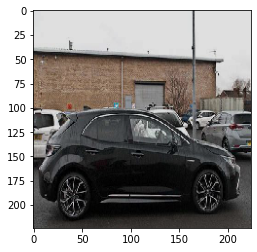

Label : Corolla


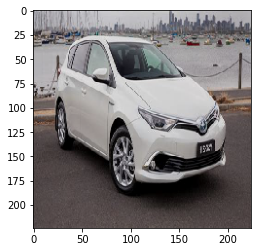

Label : Berlingo


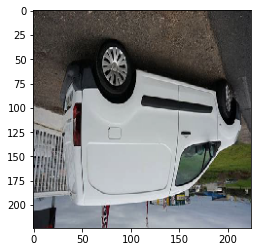

Label : Tiguan


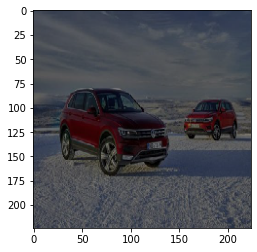

Label : 208


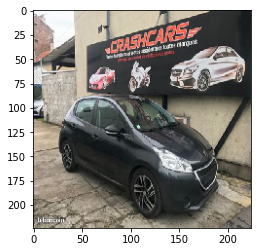

Label : 2008


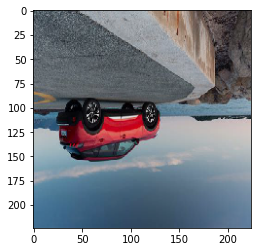

Label : Yaris


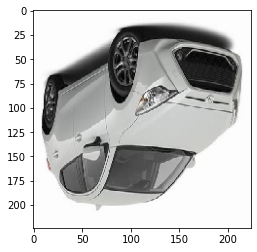

Label : Twingo


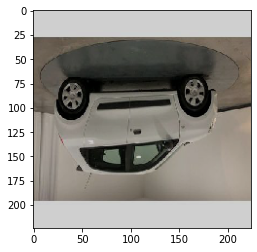

Label : Megane


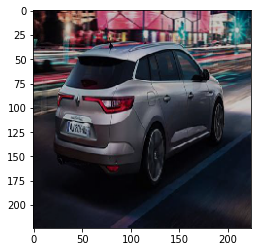

Label : 308


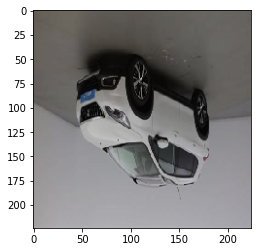

Label : C5 Aircross


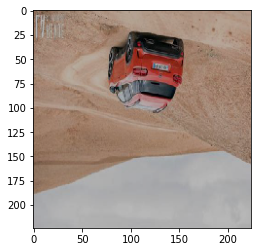

Label : C3


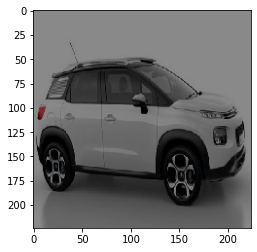

Label : Berlingo


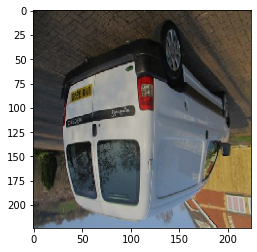

Label : Captur


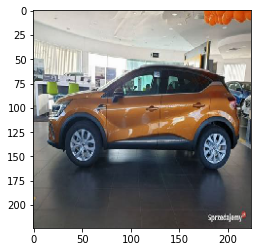

Label : C_HR


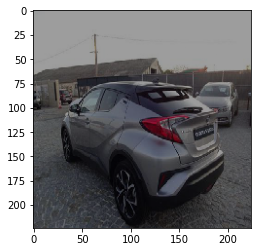

Label : Up !


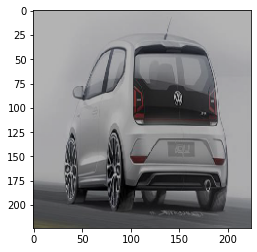

Label : Clio


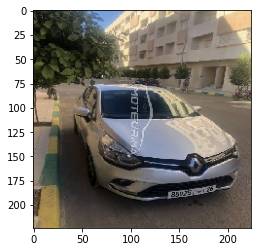

Label : 108


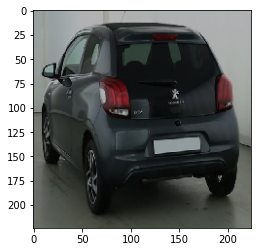

In [ ]:
# Let's visualize a group of images from the train set

from pathlib import Path

imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  print("Label :", true_label_name)
  plt.imshow(img)
  plt.show()

# Header 1
## Header 2
...

_italic_
**bold**
`code`

## MobileNet trained model

In [ ]:
# We'll use an already existing architecture: 'MobileNet' and use it to classify our cars pics

base_model = base_model = keras.applications.MobileNet(weights= 'imagenet' ,  
                                                  input_shape=( 224 , 224 , 3 ),
                                                  include_top= False )  

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# We can have a quick look at the architecture of our model

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Now we'll freeze our model so that only the custom layers will train

base_model.trainable = False

In [ ]:
# We removed the last layer to be able to adapt the model to our situation. So now let's to add our last layer.

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [ ]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Now let's practice our model

model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


82/82 [==============================] - 57s 655ms/step - loss: 5.3115 - categorical_accuracy: 0.1021 - val_loss: 3.9726 - val_categorical_accuracy: 0.1521
Epoch 2/100
82/82 [==============================] - 51s 627ms/step - loss: 3.4883 - categorical_accuracy: 0.2281 - val_loss: 3.2949 - val_categorical_accuracy: 0.2479
Epoch 3/100
82/82 [==============================] - 52s 631ms/step - loss: 2.8360 - categorical_accuracy: 0.3232 - val_loss: 2.8052 - val_categorical_accuracy: 0.3251
Epoch 4/100
82/82 [==============================] - 52s 631ms/step - loss: 2.4145 - categorical_accuracy: 0.3860 - val_loss: 2.8143 - val_categorical_accuracy: 0.3143
Epoch 5/100
82/82 [==============================] - 52s 638ms/step - loss: 2.1558 - categorical_accuracy: 0.4347 - val_loss: 2.5148 - val_categorical_accuracy: 0.3792
Epoch 6/100
82/82 [==============================] - 54s 665ms/step - loss: 2.0011 - categorical_accuracy: 0.4645 - val_loss: 2.7593 - val_categorical_accuracy: 0.3637
Epoc

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


## MobileNetV2 trained model

In [ ]:
# We'll use an already existing architecture: 'MobileNet' and use it to classify our cars pics

base_model = base_model = keras.applications.MobileNetV2(weights= 'imagenet' ,  
                                                  input_shape=( 224 , 224 , 3 ),
                                                  include_top= False )  

In [ ]:
# We can have a quick look at the architecture of our model

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Now we'll freeze our model so that only the custom layers will train

base_model.trainable = False

In [ ]:
# We removed the last layer to be able to adapt the model to our situation. So now let's to add our last layer.

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [ ]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Now let's practice our model

model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=50)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


164/164 [==============================] - 68s 390ms/step - loss: 5.1010 - categorical_accuracy: 0.1247 - val_loss: 3.7171 - val_categorical_accuracy: 0.2162
Epoch 2/100
164/164 [==============================] - 62s 381ms/step - loss: 3.2554 - categorical_accuracy: 0.2827 - val_loss: 3.0454 - val_categorical_accuracy: 0.3104
Epoch 3/100
164/164 [==============================] - 64s 392ms/step - loss: 2.7112 - categorical_accuracy: 0.3627 - val_loss: 3.3821 - val_categorical_accuracy: 0.3143
Epoch 4/100
164/164 [==============================] - 65s 394ms/step - loss: 2.3705 - categorical_accuracy: 0.4198 - val_loss: 2.8577 - val_categorical_accuracy: 0.3629
Epoch 5/100
164/164 [==============================] - 64s 393ms/step - loss: 2.0797 - categorical_accuracy: 0.4779 - val_loss: 2.5602 - val_categorical_accuracy: 0.4224
Epoch 6/100
164/164 [==============================] - 64s 393ms/step - loss: 1.8406 - categorical_accuracy: 0.5214 - val_loss: 2.4200 - val_categorical_accuracy:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


## VGG19 trained model

In [ ]:
# We'll use an already existing architecture: 'MobileNet' and use it to classify our cars pics

base_model = base_model = keras.applications.VGG19(weights= 'imagenet' ,  
                                                  input_shape=( 224 , 224 , 3 ),
                                                  include_top= False )  

In [ ]:
# We can have a quick look at the architecture of our model

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Now we'll freeze our model so that only the custom layers will train

base_model.trainable = False

In [ ]:
# We removed the last layer to be able to adapt the model to our situation. So now let's to add our last layer.

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [ ]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                12825     
Total params: 20,037,209
Trainable params: 12,825
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Now let's practice our model

model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


164/164 [==============================] - 92s 492ms/step - loss: 3.1755 - categorical_accuracy: 0.0937 - val_loss: 2.9846 - val_categorical_accuracy: 0.1498
Epoch 2/50
164/164 [==============================] - 74s 449ms/step - loss: 2.8404 - categorical_accuracy: 0.1894 - val_loss: 2.7979 - val_categorical_accuracy: 0.1876
Epoch 3/50
164/164 [==============================] - 73s 445ms/step - loss: 2.6323 - categorical_accuracy: 0.2629 - val_loss: 2.6574 - val_categorical_accuracy: 0.2625
Epoch 4/50
164/164 [==============================] - 73s 444ms/step - loss: 2.4776 - categorical_accuracy: 0.3127 - val_loss: 2.5261 - val_categorical_accuracy: 0.2996
Epoch 5/50
164/164 [==============================] - 73s 445ms/step - loss: 2.3489 - categorical_accuracy: 0.3429 - val_loss: 2.4342 - val_categorical_accuracy: 0.3127
Epoch 6/50
164/164 [==============================] - 73s 446ms/step - loss: 2.2526 - categorical_accuracy: 0.3795 - val_loss: 2.3444 - val_categorical_accuracy: 0.35

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


## Accuracy

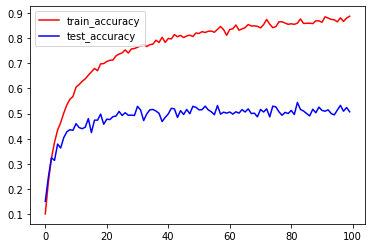

In [ ]:
# We can visualize the learning process thanks to our history attribute from our model object

plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

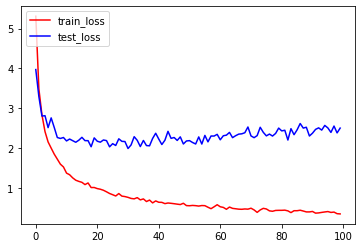

In [ ]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Now we'll see if our machine can recognize some cars pictures. We're gonna take 5 pictures of cars (3 of our selction and 2 different)

data_predict = pathlib.Path("/content/drive/MyDrive/Jedha/Final_project/cars_pic/model_predict")
print(data_predict)

In [ ]:
for pic_pred in data_predict.iterdir():
  print(pic_pred)

In [ ]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255)

In [ ]:
img_generator_pred_valid = img_generator.flow_from_directory(
    directory="/content/drive/MyDrive/Jedha/Final_project/cars_pic/model_predict",
    target_size=(224, 224),
    batch_size=4,
    shuffle=True)

In [ ]:
import os

rootdir = '/content/drive/MyDrive/Jedha/Final_project/cars_pic/cars_model' #définis le dossier où se situent les sous dossiers qui contiennent tes images
id_to_class = {} #définis un dictionnaire vide qui va servir à faire correspondre chaque entier (id) à une classe
i = 0 #initialise un itérateur

listdir_ = os.listdir(rootdir)
listdir_.sort()

for dir in listdir_: #parcours les sous-dossiers
    id_to_class[i] = dir #associe un entier comme clef à un nom de dossier (une classe) comme valeur
    i += 1 #incrémente ton itérateur

print(id_to_class) #vérifie ton dictionnaire

print(id_to_class[0]) #vérifie avec un test

In [ ]:
from pathlib import Path

imgs, labels = next(iter(img_generator_pred_valid))
prediction = model.predict(imgs)
pred_labels = tf.argmax(prediction, axis = -1)
i = 0
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_pred_valid.labels == tf.argmax(label))
  true_label_name = Path(img_generator_pred_valid.filepaths[true_file_path]).parent.name
  print('Pred :', id_to_class[pred_labels[i].numpy()])
  print("Label :", true_label_name)
  plt.imshow(img)
  plt.show()
  i+=1